# 📝 Introductory exercise regarding stratification

The goal of this exercise is to highlight one limitation of
applying blindly a k-fold cross-validation.

In this exercise we will use the iris dataset.

In [1]:
from sklearn.datasets import load_iris

data, target = load_iris(return_X_y=True, as_frame=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


We can display an interactive diagram with the following command:

In [2]:
from sklearn import set_config
set_config(display='diagram')

Create a decision tree classifier that we will use in the next experiments.

In [3]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree

DecisionTreeClassifier(random_state=0)

As a first experiment, use the utility
`sklearn.model_selection.train_test_split` to split the data into a train
and test set. Train the classifier using the train set and check the score
on the test set.

In [11]:
%%time
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"The test score: {test_score:.3f}")

The test score: 0.974
CPU times: user 9.07 ms, sys: 79 µs, total: 9.15 ms
Wall time: 7.87 ms


Now, use the utility `sklearn.model_selection.cross_val_score` with a
`sklearn.model_selection.KFold` by setting only `n_splits=3`. Check the
results on each fold. Explain the results.

In [16]:
%%time
from sklearn.model_selection import KFold, cross_val_score

n_splits=3
cv = KFold(n_splits=n_splits)
scores_tree = cross_val_score(tree, data, target,
    cv=cv, n_jobs=2)
print(f"The average score: {scores_tree.mean():.3f}")

The average score: 0.000
CPU times: user 9 ms, sys: 24.3 ms, total: 33.3 ms
Wall time: 665 ms


It is a real surprise that our model cannot correctly classify any sample in
any cross-validation split. We will now check our target's value to
understand the issue.

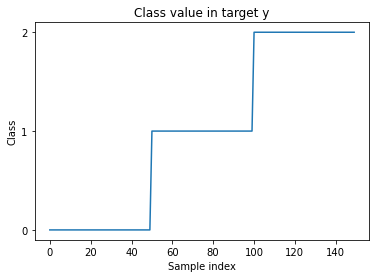

In [13]:
import matplotlib.pyplot as plt

target.plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(target.unique())
_ = plt.title("Class value in target y")

We see that the target vector `target` is ordered. It will have some
unexpected consequences when using the `KFold` cross-validation. To
illustrate the consequences, we will show the class count in each fold of the
cross-validation in the train and test set.

Let's compute the class counts for both the training and testing sets using
the `KFold` cross-validation, and plot these information in a bar plot.

We will iterate given the number of split and check how many samples of each
are present in the training and testing set. We will store the information
into two distincts lists; one for the training set and one for the testing
set.

In [14]:
import pandas as pd

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]
    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())

To plot the information on a single figure, we will concatenate the
information regarding the fold within the same dataset. We can represent graphically this information with bar plots.

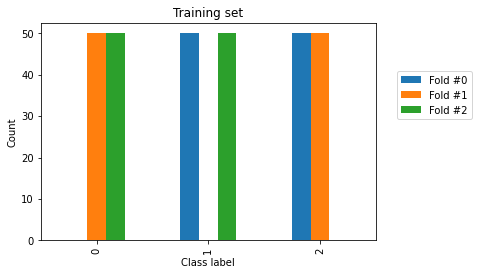

In [17]:
train_cv_counts = pd.concat(train_cv_counts, axis=1,
    keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"

train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

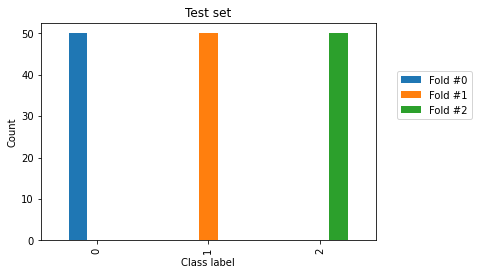

In [18]:
test_cv_counts = pd.concat(test_cv_counts, axis=1,
    keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts.index.name = "Class label"

test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

We can confirm that in each fold, only two of the three classes are present in the training set and all samples of the remaining class is used as a test set. So our model is unable to predict this class that was unseen during the training stage.